In [47]:
import pandas as pd
import numpy as np
import os
from IPython.display import Audio
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU, Bidirectional, Conv1D, MaxPooling1D, Flatten, BatchNormalization, Activation, Masking, Input, InputLayer, Reshape
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import ResNet50V2, ResNet101V2, ResNet152V2, VGG19, EfficientNetV2M, EfficientNetB0, EfficientNetB4
from tensorflow.python.keras import optimizers
from tensorflow.keras.optimizers import SGD

In [48]:
file_name_dataset = "RAVDESS"
dataset_ravdess_dir = "../Dataset/RAVDESS/"
ravdess_dir_list = os.listdir(dataset_ravdess_dir)

In [49]:
emotion_dict = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised"
}

In [50]:
emotion_list = []
path_list = []

for dir in ravdess_dir_list:
    for audio_file in os.listdir(dataset_ravdess_dir + dir):
        emotion_segment = audio_file.split("-")[2]

        if emotion_segment in emotion_dict:
            emotion_list.append(emotion_dict[emotion_segment])
        else:
            emotion_list.append("unknown")

        audio_file_path = os.path.join(dataset_ravdess_dir, dir, audio_file)
        path_list.append(audio_file_path)

ravdess_df = pd.DataFrame({'Emotion': emotion_list, 'Path': path_list})
ravdess_df.to_csv("tess_df.csv", index = False)
ravdess_df.head()

,Emotion,Path
0,neutral,../Dataset/RAVDESS/Actor_01\03-01-01-01-01-01-...
1,neutral,../Dataset/RAVDESS/Actor_01\03-01-01-01-01-02-...
2,neutral,../Dataset/RAVDESS/Actor_01\03-01-01-01-02-01-...
3,neutral,../Dataset/RAVDESS/Actor_01\03-01-01-01-02-02-...
4,calm,../Dataset/RAVDESS/Actor_01\03-01-02-01-01-01-...


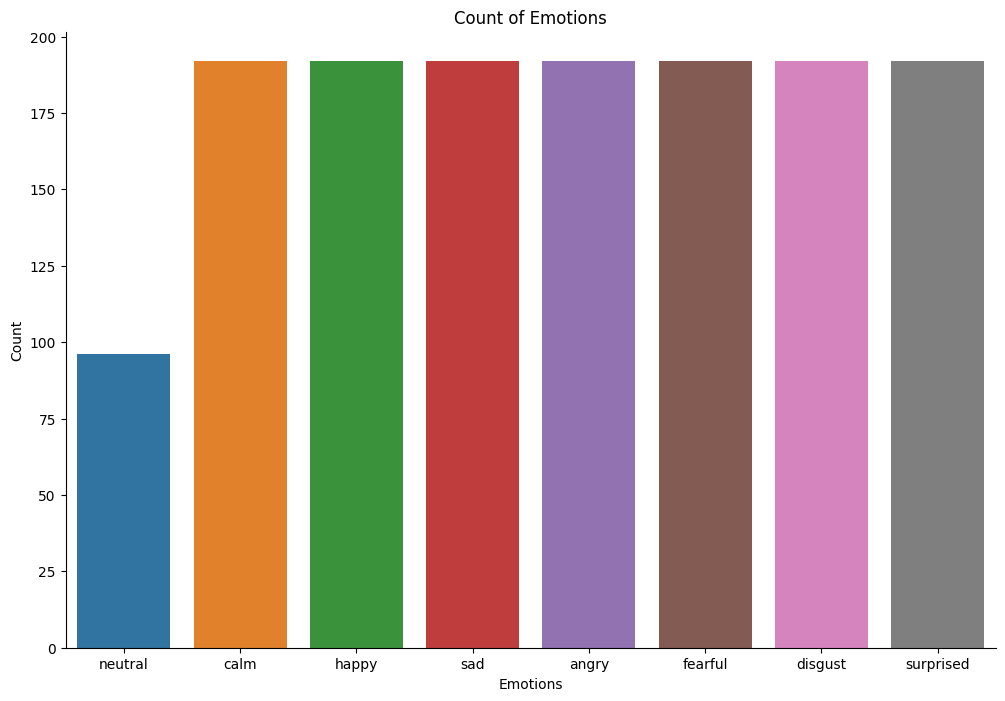

In [51]:
plt.figure(figsize=(12, 8))
plt.title('Count of Emotions')
sns.countplot(x = ravdess_df.Emotion)
plt.ylabel('Count')
plt.xlabel('Emotions')
sns.despine(top = True, right = True, left = False, bottom = False)
plt.show()

In [52]:
def noise(data):
  noise_amp = 0.04 * np.random.uniform() * np.amax(data)
  data = data + noise_amp * np.random.normal(size = data.shape[0])
  return data

def time_stretch(data, rate = 0.8):
  return librosa.effects.time_stretch(data, rate = rate)

def shift(data, steps_range = (-5, 5)):
  shift_range = int(np.random.uniform(steps_range[0], steps_range[1]) * 1000)
  return np.roll(data, shift_range)

def pitch_shift(data, sampling_rate, n_steps = 0.7):
  return librosa.effects.pitch_shift(data, sr = sampling_rate, n_steps = n_steps)

def random_time_stretch(data, stretch_factor_range = (0.8, 1.25)):
  random_stretch_factor = np.random.uniform(stretch_factor_range[0], stretch_factor_range[1])

  augmented_data = time_stretch(data, random_stretch_factor)

  if len(augmented_data) > len(data):
    augmented_data = augmented_data[:len(data)]
  else:
    padded_augmented_data = np.zeros_like(data)
    padded_augmented_data[:len(augmented_data)] = augmented_data
    augmented_data = padded_augmented_data

  return augmented_data

def random_pitch_shift(data, sampling_rate, steps_range=(-4, 4)):
  n_steps = np.random.randint(steps_range[0], steps_range[1] + 1)  
  return pitch_shift(data, sampling_rate, n_steps)

In [53]:
def extract_mel(data, sr, n_mels=128, fmax=8000):
    mel_spec = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=n_mels, fmax=fmax)
    return mel_spec;

def extract_log_mel_spec(data, sr, n_mels=128, fmax=8000):
    log_mel_spec = librosa.power_to_db(extract_mel(data, sr, n_mels, fmax))
    return log_mel_spec;

def extract_mfcc(data, sr, n_mfcc=13):
    mfcc = librosa.feature.mfcc(y = data, sr = sr, n_mfcc=n_mfcc)
    return mfcc;

def extract_delta_mfcc(data, sr, n_mfcc=13):
    mfcc = extract_mfcc(data, sr, n_mfcc)
    delta_mfcc = librosa.feature.delta(mfcc)
    return delta_mfcc;

def extract_delta_delta_mfcc(data, sr, n_mfcc=13):
    mfcc = extract_mfcc(data, sr, n_mfcc)
    delta2_mfcc = librosa.feature.delta(mfcc, order=2)
    return delta2_mfcc;

def extract_zcr(data):
    zcr = librosa.feature.zero_crossing_rate(y=data)
    return zcr

def extract_rms(data):
    rms = librosa.feature.rms(y=data)
    return rms

In [54]:
# feature_extraction_techniques = ["MFCC", "Delta MFCC", "Delta Delta MFCC"]
# feature_extraction_techniques = ["MFCC Mean 40", "Delta MFCC Mean 40", "Delta Delta MFCC Mean 40"]
feature_extraction_techniques = ["MFCC Mean 40"]

file_name_feat_extract = " & ".join(feature_extraction_techniques)

def extract_features(data, sr, n_mfcc=40):
    # MEAN
    features = np.array([])
    mfcc = extract_mfcc(data, sr, n_mfcc).T
    delta_mfcc = extract_delta_mfcc(data, sr, n_mfcc).T
    delta_delta_mfcc = extract_delta_delta_mfcc(data, sr, n_mfcc).T
    mfcc_mean = np.mean(mfcc, axis=0)
    delta_mfcc_mean = np.mean(delta_mfcc, axis=0)
    delta_delta_mfcc_mean = np.mean(delta_delta_mfcc, axis=0)
    # mfcc_min = np.min(mfcc, axis=0)
    # mfcc_max = np.max(mfcc, axis=0)
    # mfcc_std = np.std(mfcc, axis=0)
    # zcr = np.mean(extract_zcr(data))
    # rms = np.mean(extract_rms(data))
    features = np.hstack((features, mfcc_mean))

    # ENTIRE FEATURE
    # mfcc = extract_mfcc(data, sr).T
    # delta_mfcc = extract_delta_mfcc(data, sr).T
    # delta_delta_mfcc = extract_delta_delta_mfcc(data, sr).T
    # features = np.concatenate((mfcc, delta_mfcc, delta_delta_mfcc), axis=1)
    
    return features

In [55]:
# data_augmentation_techniques = ["Noise", "Random Time Stretch", "Random Pitch Shift"]
# data_augmentation_techniques = ["Noise 0.04", "Low Speed 0.75", "Stretched 0.7", "High Speed 1.25", "Pitch Shift 0.7", "Shift (-5, 5)"]
data_augmentation_techniques = ["Noise 0.04", "Low Speed 0.75", "High Speed 1.25", "Pitch Shift 0.7", "Shift (-5, 5)"]

file_name_data_aug = " & ".join(data_augmentation_techniques)

def get_features(path):
    data, sampling_rate = librosa.load(path, duration=3, offset=0.5)

    noisy_data = noise(data)

    lowspeed_data = time_stretch(data, rate=0.75) #Ignore this
    stretched_data = time_stretch(data, rate=0.7) #Ignore this
    highspeed_data = time_stretch(data, rate=1.25) #Ignore this
    pitch_shift_data = pitch_shift(data, sampling_rate, n_steps=0.7) #Ignore this
    shift_data = shift(data, (-5, 5)) #Ignore this

    random_time_stretch_data = random_time_stretch(data, (0.8, 1.25))
    random_pitch_shift_data = random_pitch_shift(data, sampling_rate, (-4, 4))

    features = extract_features(data, sampling_rate)
    noisy_features = extract_features(noisy_data, sampling_rate)
    
    lowspeed_features = extract_features(lowspeed_data, sampling_rate) #Ignore this
    stretched_features = extract_features(stretched_data, sampling_rate) #Ignore this
    highspeed_features = extract_features(highspeed_data, sampling_rate) #Ignore this
    pitch_shift_features = extract_features(pitch_shift_data, sampling_rate) #Ignore this
    shift_features = extract_features(shift_data, sampling_rate) #Ignore this

    random_time_stretch_features = extract_features(random_time_stretch_data, sampling_rate)
    random_pitch_shift_features = extract_features(random_pitch_shift_data, sampling_rate)

    # result = np.vstack((features, noisy_features, random_time_stretch_features, random_pitch_shift_features))
    result = np.vstack((features, noisy_features, lowspeed_features, highspeed_features, pitch_shift_features, shift_features))

    return result

In [56]:
filename = file_name_dataset + " # " + file_name_feat_extract + " # " + file_name_data_aug

def create_feature_dataframe(dataframe):
    feature_list = []
    emotion_list = []

    for path, emotion in tqdm(zip(dataframe.Path, dataframe.Emotion), total=len(dataframe)):
        features = get_features(path)
        for elements in features:
            feature_list.append(elements)
            emotion_list.append(emotion)

    df = pd.DataFrame({'Emotion': emotion_list})
    df = pd.concat([df, pd.DataFrame(feature_list)], axis=1)
    df.to_csv(filename + '.csv', index=False)

    return df

In [57]:
file_exists = os.path.exists(filename + '.csv')

if file_exists:
    df = pd.read_csv(filename + '.csv')
else:
    df = create_feature_dataframe(ravdess_df)

df.head()

,Emotion,0,1,2,3,4,5,6,7,8,...,30,31,32,33,34,35,36,37,38,39
0,neutral,-670.195435,65.063850,0.888954,14.715979,9.182164,0.660575,-3.846836,-3.583946,-12.959006,...,-2.351098,-2.504727,-3.151507,-2.190899,-3.801760,-1.813088,-1.261222,-2.144954,-4.152173,-1.779615
1,neutral,-437.411376,24.860678,7.356011,8.004017,5.143942,0.050777,-3.462119,-6.175004,-7.927267,...,-0.913083,-1.325904,-1.392386,-1.818780,-1.903436,-0.807370,-0.963922,-1.762706,-2.651064,-2.611878
2,neutral,-691.445679,62.221443,-0.300504,14.352509,8.497726,0.746647,-4.348557,-4.798969,-14.069670,...,-2.381158,-2.261819,-2.873888,-1.883212,-4.045451,-1.785669,-1.113154,-2.164787,-4.364875,-1.768830
3,neutral,-712.516907,66.194984,1.424330,16.236750,9.380598,1.506902,-4.124938,-3.517112,-13.283334,...,-1.922169,-2.280859,-3.436191,-1.829611,-4.056078,-1.664588,-0.654646,-1.566690,-4.341530,-1.645019
4,neutral,-697.627258,62.472347,-1.029173,15.987646,7.447986,-0.467146,-5.220094,-5.383532,-13.847498,...,-4.750515,-3.052244,-4.137149,-2.542254,-3.379075,-0.843549,-2.677613,-4.869622,-3.312335,-3.609416


In [58]:
X = df.iloc[:, 1:].values
Y = df['Emotion'].values

In [59]:
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [60]:
x_train, x_val_test, y_train, y_val_test = train_test_split(X, Y, test_size=0.2, random_state=42, shuffle=True)
x_validation, x_test, y_validation, y_test = train_test_split(x_val_test, y_val_test, test_size=0.5, random_state=42, shuffle=True)

In [61]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_validation = scaler.transform(x_validation)
x_test = scaler.transform(x_test)

x_train.shape, y_train.shape, x_validation.shape, y_validation.shape, x_test.shape, y_test.shape

((6912, 40), (6912, 8), (864, 40), (864, 8), (864, 40), (864, 8))

In [62]:
X_train = x_train.reshape(x_train.shape[0] , x_train.shape[1] , 1)
X_test = x_test.reshape(x_test.shape[0] , x_test.shape[1] , 1)
X_validation = x_validation.reshape(x_validation.shape[0] , x_validation.shape[1] , 1)
X_train.shape, y_train.shape, X_validation.shape, y_validation.shape, X_test.shape, y_test.shape

((6912, 40, 1), (6912, 8), (864, 40, 1), (864, 8), (864, 40, 1), (864, 8))

In [63]:
def evaluate_model(model):
    loss, accuracy = model.evaluate(X_test, y_test, verbose=1)

    print(f'Test Loss: {loss}')
    print(f'Test Accuracy: {accuracy}')

In [64]:
def plot_history(history):
    plt.figure(figsize=(12, 4))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

In [65]:
def simplify_label(label):
    if 'angry' in label:
        return 'angry'
    elif 'disgust' in label:
        return 'disgust'
    elif 'fear' in label:
        return 'fear'
    elif 'happy' in label:
        return 'happy'
    elif 'sad' in label:
        return 'sad'
    elif 'surprise' in label:
        return 'surprise'
    elif 'neutral' in label:
        return 'neutral'
    else:
        return label

In [66]:
def create_model_summary(model_type):
    test_prediction = model_type.predict(X_test)

    prediction_actual_df = pd.DataFrame({
    'Predicted': encoder.inverse_transform(test_prediction).flatten(),
    'Actual': encoder.inverse_transform(y_test).flatten()
    })

    prediction_actual_df.head()

    modified_df = prediction_actual_df.copy()
    modified_df['Actual'] = modified_df['Actual'].apply(simplify_label)
    modified_df['Predicted'] = modified_df['Predicted'].apply(simplify_label)

    res_mat = confusion_matrix(modified_df['Actual'], modified_df['Predicted'])
    plt.figure(figsize=(10, 7))
    sns.heatmap(res_mat, annot=True, fmt='d', cmap='Blues',
                xticklabels=modified_df['Predicted'].unique(), 
                yticklabels=modified_df['Actual'].unique())
    plt.xlabel('Predicted Labels')
    plt.ylabel('Actual Labels')
    plt.title('Confusion Matrix')
    plt.show()

    print(classification_report(modified_df['Actual'], modified_df['Predicted']))

    accuracy = accuracy_score(modified_df['Actual'], modified_df['Predicted'])
    print(f"Accuracy: {round(accuracy * 100, 2)}%")

In [67]:
resnet50_weights_path = '../ResNet/resnet50v2_weights_tf_dim_ordering_tf_kernels_notop.h5'
resnet101_weights_path = '../ResNet/resnet101v2_weights_tf_dim_ordering_tf_kernels_notop.h5'
resnet152_weights_path = '../ResNet/resnet152v2_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [68]:
def create_resnet_model(model_type, epochs, filename):
    input_shape = (X_train.shape[1], X_train.shape[2], 1)
    input_layer = Input(shape=input_shape)

    model_map = {
        'ResNet50V2': ResNet50V2,
        'ResNet101V2': ResNet101V2,
        'ResNet152V2': ResNet152V2
    }

    if model_type == 'ResNet50V2':
        base_model = ResNet50V2(weights=None, include_top=False, input_tensor=input_layer, pooling='avg')
    elif model_type == 'ResNet101V2':
        base_model = ResNet101V2(weights=None, include_top=False, input_tensor=input_layer, pooling='avg')
    elif model_type == 'ResNet152V2':
        base_model = ResNet152V2(weights=None, include_top=False, input_tensor=input_layer, pooling='avg')

    if model_type not in model_map:
        raise ValueError("Invalid model_type provided. Please choose from ResNet50V2, ResNet101V2 or ResNet152V2")

    base_model = model_map[model_type](weights=None, include_top=False, input_tensor=input_layer, pooling='avg')

    x = base_model.output
    output_layer = Dense(8, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=output_layer)
    model.summary()
    
    sgd = SGD(lr = 0.01, decay = 1e-6, momentum = 0.9, nesterov = True)
    model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
        
    reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=3, min_lr=0.00001)
    checkpoint = ModelCheckpoint(filepath=filename + '_best.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
    early_stop = EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)

    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        validation_data=(X_validation, y_validation),
        callbacks=[reduce_lr, early_stop, checkpoint]
    )
    
    return model, history

Training model: ResNet50V2
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 40, 1, 1)]   0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 46, 7, 1)     0           ['input_6[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 20, 1, 64)    3200        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 22, 3, 64)    0           ['conv1_conv[0][0]']             
                                                                 

c:\Users\Daniel\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/20
216/216 [==============================] - ETA: 0s - loss: 1.9750 - accuracy: 0.3595
Epoch 1: val_accuracy improved from -inf to 0.48611, saving model to RAVDESS ResNet50V2_best.h5
216/216 [==============================] - 52s 214ms/step - loss: 1.9750 - accuracy: 0.3595 - val_loss: 1.7582 - val_accuracy: 0.4861 - lr: 0.0100
Epoch 2/20
216/216 [==============================] - ETA: 0s - loss: 1.3171 - accuracy: 0.5516
Epoch 2: val_accuracy improved from 0.48611 to 0.68287, saving model to RAVDESS ResNet50V2_best.h5
216/216 [==============================] - 20s 92ms/step - loss: 1.3171 - accuracy: 0.5516 - val_loss: 0.9059 - val_accuracy: 0.6829 - lr: 0.0100
Epoch 3/20
216/216 [==============================] - ETA: 0s - loss: 0.9281 - accuracy: 0.6863
Epoch 3: val_accuracy improved from 0.68287 to 0.75347, saving model to RAVDESS ResNet50V2_best.h5
216/216 [==============================] - 19s 89ms/step - loss: 0.9281 - accuracy: 0.6863 - val_loss: 0.7785 - val_accuracy:

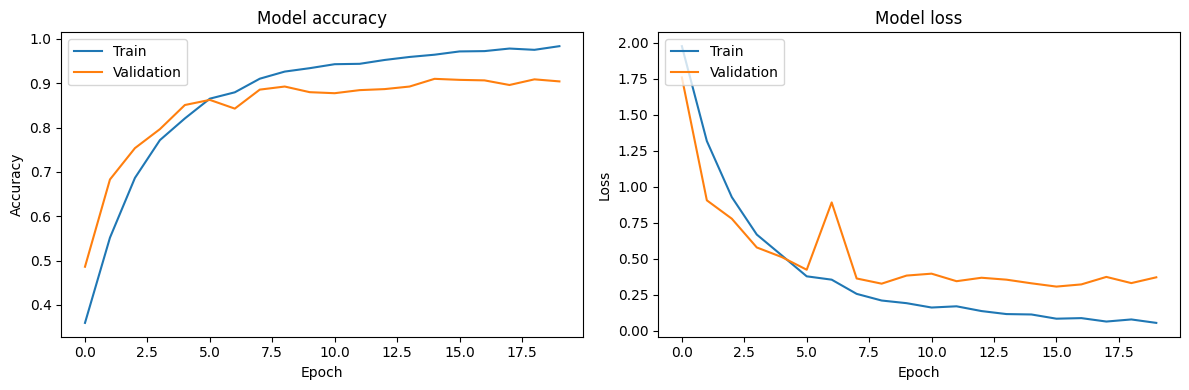

27/27 [==============================] - 1s 16ms/step


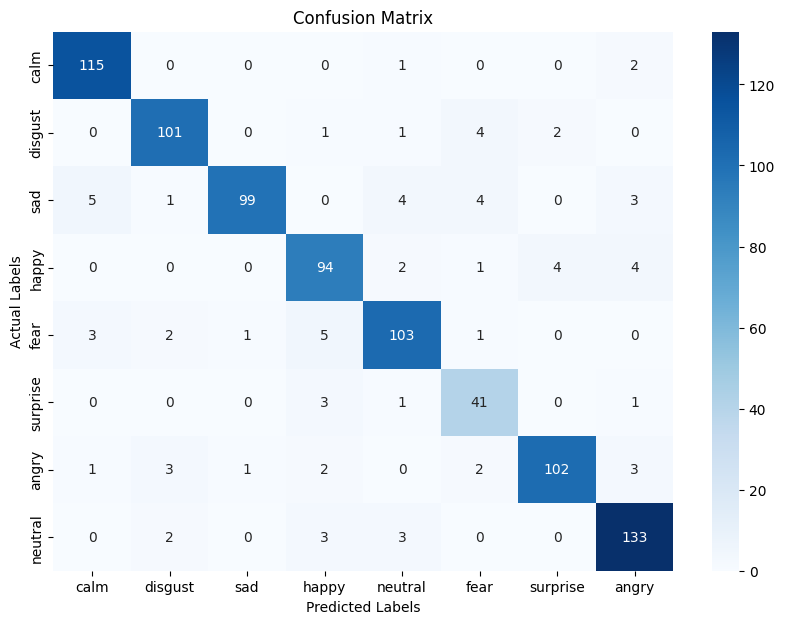

              precision    recall  f1-score   support

       angry       0.93      0.97      0.95       118
        calm       0.93      0.93      0.93       109
     disgust       0.98      0.85      0.91       116
        fear       0.87      0.90      0.88       105
       happy       0.90      0.90      0.90       115
     neutral       0.77      0.89      0.83        46
         sad       0.94      0.89      0.92       114
    surprise       0.91      0.94      0.93       141

    accuracy                           0.91       864
   macro avg       0.90      0.91      0.91       864
weighted avg       0.91      0.91      0.91       864

Accuracy: 91.2%
Training model: ResNet101V2
Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 40, 1, 1)]   0           []                       

c:\Users\Daniel\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


216/216 [==============================] - ETA: 0s - loss: 2.1200 - accuracy: 0.2970
Epoch 1: val_accuracy improved from -inf to 0.31481, saving model to RAVDESS ResNet101V2_best.h5
216/216 [==============================] - 38s 138ms/step - loss: 2.1200 - accuracy: 0.2970 - val_loss: 3.7009 - val_accuracy: 0.3148 - lr: 0.0100
Epoch 2/20
216/216 [==============================] - ETA: 0s - loss: 1.6347 - accuracy: 0.4376
Epoch 2: val_accuracy improved from 0.31481 to 0.48958, saving model to RAVDESS ResNet101V2_best.h5
216/216 [==============================] - 30s 139ms/step - loss: 1.6347 - accuracy: 0.4376 - val_loss: 1.4449 - val_accuracy: 0.4896 - lr: 0.0100
Epoch 3/20
216/216 [==============================] - ETA: 0s - loss: 1.2306 - accuracy: 0.5625
Epoch 3: val_accuracy improved from 0.48958 to 0.65278, saving model to RAVDESS ResNet101V2_best.h5
216/216 [==============================] - 40s 187ms/step - loss: 1.2306 - accuracy: 0.5625 - val_loss: 0.9731 - val_accuracy: 0.652

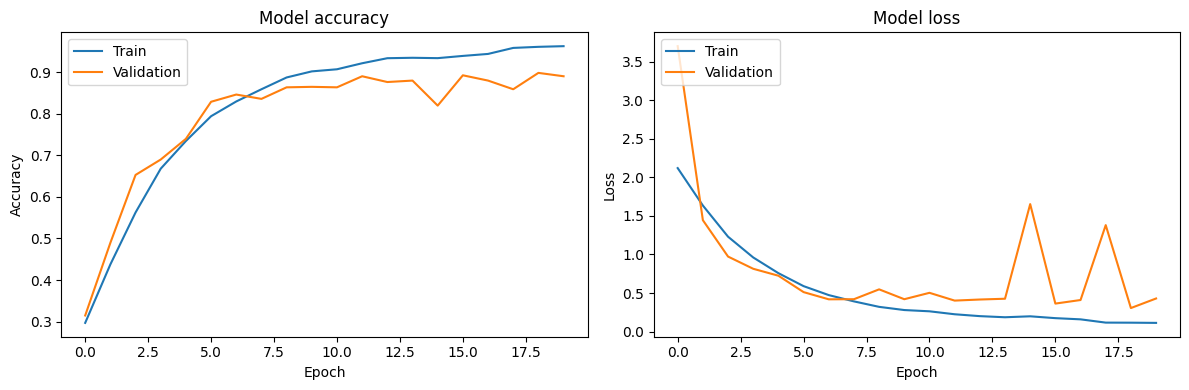

27/27 [==============================] - 2s 32ms/step


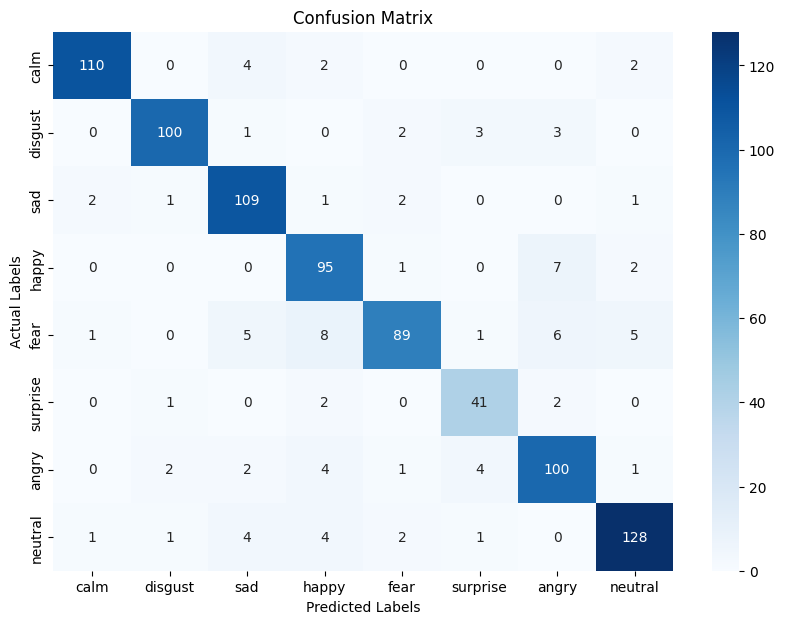

              precision    recall  f1-score   support

       angry       0.96      0.93      0.95       118
        calm       0.95      0.92      0.93       109
     disgust       0.87      0.94      0.90       116
        fear       0.82      0.90      0.86       105
       happy       0.92      0.77      0.84       115
     neutral       0.82      0.89      0.85        46
         sad       0.85      0.88      0.86       114
    surprise       0.92      0.91      0.91       141

    accuracy                           0.89       864
   macro avg       0.89      0.89      0.89       864
weighted avg       0.90      0.89      0.89       864

Accuracy: 89.35%
Training model: ResNet152V2
Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 40, 1, 1)]   0           []                      

c:\Users\Daniel\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


216/216 [==============================] - ETA: 0s - loss: 2.1970 - accuracy: 0.2734
Epoch 1: val_accuracy improved from -inf to 0.26620, saving model to RAVDESS ResNet152V2_best.h5
216/216 [==============================] - 52s 183ms/step - loss: 2.1970 - accuracy: 0.2734 - val_loss: 3.7702 - val_accuracy: 0.2662 - lr: 0.0100
Epoch 2/20
216/216 [==============================] - ETA: 0s - loss: 1.7364 - accuracy: 0.3802
Epoch 2: val_accuracy improved from 0.26620 to 0.39236, saving model to RAVDESS ResNet152V2_best.h5
216/216 [==============================] - 40s 185ms/step - loss: 1.7364 - accuracy: 0.3802 - val_loss: 1.5463 - val_accuracy: 0.3924 - lr: 0.0100
Epoch 3/20
216/216 [==============================] - ETA: 0s - loss: 1.4931 - accuracy: 0.4602
Epoch 3: val_accuracy improved from 0.39236 to 0.51389, saving model to RAVDESS ResNet152V2_best.h5
216/216 [==============================] - 41s 191ms/step - loss: 1.4931 - accuracy: 0.4602 - val_loss: 1.3771 - val_accuracy: 0.513

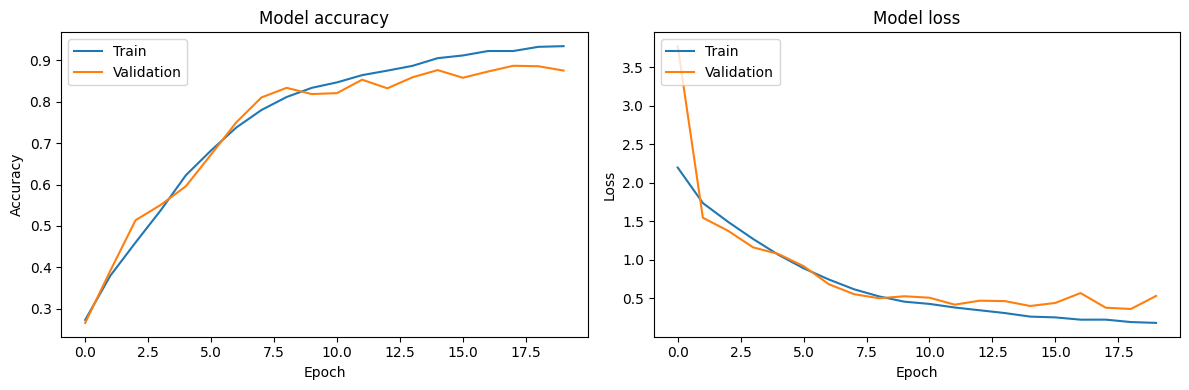

27/27 [==============================] - 5s 116ms/step


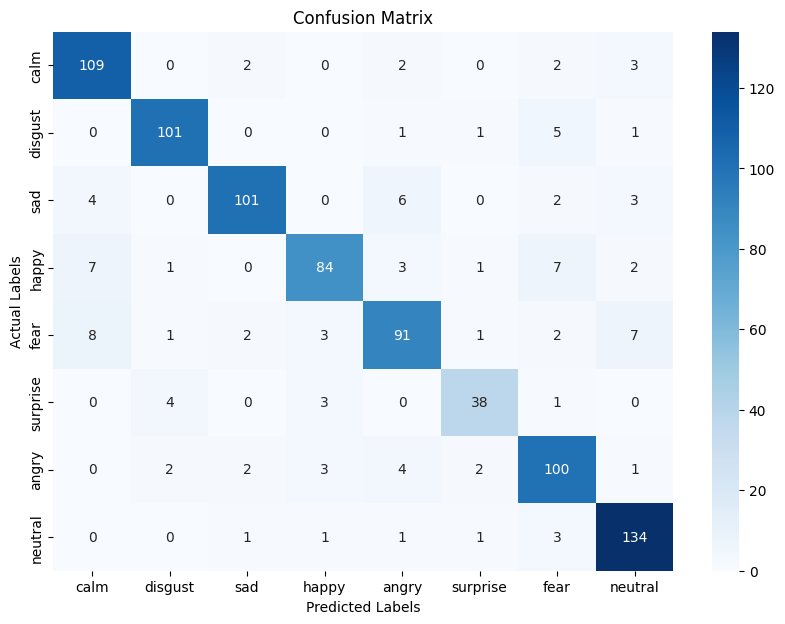

              precision    recall  f1-score   support

       angry       0.85      0.92      0.89       118
        calm       0.93      0.93      0.93       109
     disgust       0.94      0.87      0.90       116
        fear       0.89      0.80      0.84       105
       happy       0.84      0.79      0.82       115
     neutral       0.86      0.83      0.84        46
         sad       0.82      0.88      0.85       114
    surprise       0.89      0.95      0.92       141

    accuracy                           0.88       864
   macro avg       0.88      0.87      0.87       864
weighted avg       0.88      0.88      0.88       864

Accuracy: 87.73%


In [69]:
model_types = ['ResNet50V2', 'ResNet101V2', 'ResNet152V2']

for model_type in model_types:
    print(f"Training model: {model_type}")
    model, history = create_resnet_model(model_type, 20, 'RAVDESS ' + model_type)
    evaluate_model(model)
    plot_history(history)
    create_model_summary(model)